# Listwise ranking

### Next purchase pridiction

This is a competition notebook for [SberMarket Inclass challenge](https://www.kaggle.com/c/sbermarket-internship-competition).

The dataset is the purchase history of twenty thousand customers for a couple of years. The data contains statistics for each purchase (without specifying the quantity of purchased goods), there are only the list of purchased categories (a total of 881 categories).

The challenge is to predict the next order, **regardless of the time of the next order** and regardless of the number of purchased items of each category.<br>

In the basic ranking tutorial, we trained a model that can predict ratings for user/categories pairs. The model was trained to minimize the mean squared error of predicted ratings.

We do not need ranking models to predict scores with great accuracy. Instead, we care more about the ability of the model to generate an ordered list of items that matches the user's preference ordering.

Instead of optimizing the model's predictions on individual query/item pairs, we can optimize the model's ranking of a list as a whole. This method is called listwise ranking.

In this tutorial, we will use TensorFlow Recommenders to build listwise ranking models. To do so, we will make use of ranking losses and metrics provided by TensorFlow Ranking, a TensorFlow package that focuses on learning to rank.

## Preliminaries

If TensorFlow Ranking is not available in your runtime environment, you can install it using pip:

In [1]:
# pip install tensorflow-recommenders
# pip install tensorflow-ranking
# pip install --upgrade tensorflow-datasets

We can then import all the necessary packages:

In [1]:
import os
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import pprint
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
from sklearn import preprocessing
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs

In [2]:
raw = pd.read_csv(
    os.path.join('..','data','train.csv'))

sub = pd.read_csv(
    os.path.join('..','data','sample_submission.csv'))

### 1. Training dataset creation and feature engineering

```order_number``` - order counter for each user<br>
```user_id``` - user ID<br>
```category``` - category<br>

Если пользователь заказал один раз он не попадет в список последних заказов.

In [3]:
%%time
# sparse matrix for temporary use
train_raw = pd.get_dummies(raw, columns = ['cart'], prefix='', prefix_sep='', dtype='bool')
train_raw = train_raw.groupby(['user_id', 'order_completed_at']).any().reset_index()

# order counter for each use
train_raw['order_number'] = train_raw.groupby(['user_id']).cumcount()
train_raw = train_raw.drop('order_completed_at', axis=1)

# separate datasets by the last purchase
last_order = train_raw.groupby(['user_id'])['order_number'].transform(max) == train_raw['order_number']
train = train_raw[~last_order].groupby('user_id').sum().reset_index()
train = train.drop('order_number', axis=1)
valid = train_raw[last_order].groupby('user_id').sum().reset_index()

Wall time: 51.8 s


In [4]:
train_melt = pd.melt(train, id_vars=['user_id'],var_name='category', value_name='count')
train_melt = train_melt[train_melt['count']!=0]

In [5]:
# total purchase counter for each user
order_number = valid[['user_id', 'order_number']].set_index('user_id').squeeze()
valid = valid.drop('order_number', axis=1)
train_melt['orders_total']= train_melt['user_id'].map(order_number)

In [6]:
valid_melt = pd.melt(valid, id_vars=['user_id'],var_name='category', value_name='count')
valid_melt = valid_melt[valid_melt['count']!=0]

In [7]:
valid_melt = valid_melt.drop('count', 1)

<ipython-input-7-3653b2435b4b>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  valid_melt = valid_melt.drop('count', 1)


In [8]:
#average amount of each category in  customer's purchase
train_melt['rating'] = train_melt['count'] / train_melt['orders_total']

In [9]:
train_melt = train_melt.drop(['orders_total', 'count'], axis=1)

In [10]:
train_dict = train_melt.to_dict('records')
valid_dict = valid_melt.to_dict('records')

In [11]:
train_melt

,user_id,category,rating
2,2,0,0.071429
8,8,0,0.142857
9,9,0,0.022222
12,12,0,0.050000
13,13,0,0.187500
...,...,...,...
17610280,10280,880,0.250000
17613281,13281,880,0.333333
17613965,13965,880,0.250000
17616977,16977,880,0.100000


In [12]:
train_melt[['rating']].describe().round(2)

,rating
count,1031269.00
mean,0.28
std,0.23
min,0.00
25%,0.10
50%,0.20
75%,0.40
max,1.00


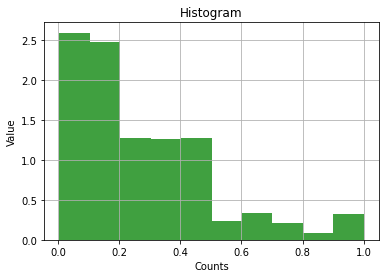

In [13]:
import matplotlib.pyplot as plt
# the histogram of the data
n, bins, patches = plt.hist(train_melt['rating'], 10, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Counts')
plt.ylabel('Value')
plt.title('Histogram')
plt.grid(True)
plt.show()

In [14]:
Train_set, Test_set = train_test_split(train_dict, test_size = 0.2,
                                        stratify = None, random_state = 17)

In [15]:
print(f'Trein : {len(Train_set)} , Test : {len(Test_set)} ')

Trein : 825015 , Test : 206254 


In [16]:
unique_category = np.unique(train_melt.category).astype('str')
unique_user_ids = np.unique(train_raw.user_id).astype('str')

## Data preprocessing

However, we cannot use the MovieLens dataset for list optimization directly. To perform listwise optimization, we need to have access to a list of movies each user has rated, but each example in the MovieLens 100K dataset contains only the rating of a single movie.

To get around this we transform the dataset so that each example contains a user id and a list of movies rated by that user. Some movies in the list will be ranked higher than others; the goal of our model will be to make predictions that match this ordering.

To do this, we use the tfrs.examples.movielens.movielens_to_listwise helper function. It takes the MovieLens 100K dataset and generates a dataset containing list examples as discussed above. The implementation details can be found in the source code.

In [17]:
import array
import collections
from typing import Dict, List, Optional, Text, Tuple

In [18]:
def _create_feature_dict() -> Dict[Text, List[tf.Tensor]]:
    """Helper function for creating an empty feature dict for defaultdict."""
    return {"category": [], "user_rating": []}

In [19]:
def _sample_list(
    feature_lists: Dict[Text, List[tf.Tensor]],
    num_examples_per_list: int,
    random_state: Optional[np.random.RandomState] = None,
) -> Tuple[tf.Tensor, tf.Tensor]:
    
    """Function for sampling a list example from given feature lists."""
    
    if random_state is None:
        random_state = np.random.RandomState()

    sampled_indices = random_state.choice(
      range(len(feature_lists["category"])),
      size=num_examples_per_list,
      replace=False,
    )
    sampled_movie_titles = [
      feature_lists["category"][idx] for idx in sampled_indices
    ]
    sampled_ratings = [
      feature_lists["user_rating"][idx] for idx in sampled_indices
    ]

    return (
      tf.concat(sampled_movie_titles, 0),
      tf.concat(sampled_ratings, 0))

In [20]:
def sample_listwise(
    rating_dataset: tf.data.Dataset,
    num_list_per_user: int = 10,
    num_examples_per_list: int = 10,
    seed: Optional[int] = None,
) -> tf.data.Dataset:
    
    """Function for converting the MovieLens 100K dataset to a listwise dataset.
      Args:
          rating_dataset:
            The MovieLens ratings dataset loaded from TFDS with features
            "movie_title", "user_id", and "user_rating".
          num_list_per_user:
            An integer representing the number of lists that should be sampled for
            each user in the training dataset.
          num_examples_per_list:
            An integer representing the number of movies to be sampled for each list
            from the list of movies rated by the user.
          seed:
            An integer for creating `np.random.RandomState`.
      Returns:
          A tf.data.Dataset containing list examples.
          Each example contains three keys: "user_id", "movie_title", and
          "user_rating". "user_id" maps to a string tensor that represents the user
          id for the example. "movie_title" maps to a tensor of shape
          [sum(num_example_per_list)] with dtype tf.string. It represents the list
          of candidate movie ids. "user_rating" maps to a tensor of shape
          [sum(num_example_per_list)] with dtype tf.float32. It represents the
          rating of each movie in the candidate list.
      """
    
    random_state = np.random.RandomState(seed)
    example_lists_by_user = collections.defaultdict(_create_feature_dict)

    category_vocab = set()

    for example in train_dict:

        user_id = str(example["user_id"])

        example_lists_by_user[user_id]["category"].append(
            tf.constant(str(example['category'])))
            
        example_lists_by_user[user_id]["user_rating"].append(
            tf.constant(example["rating"], dtype=tf.float64))

        category_vocab.add(str(example["category"]))

    tensor_slices = {"user_id": [], "category": [], "user_rating": []}

    for user_id, feature_lists in example_lists_by_user.items():
        for _ in range(num_list_per_user):

          # Drop the user if they don't have enough ratings.
            if len(feature_lists["category"]) < num_examples_per_list:
                continue

            sampled_category, sampled_ratings = _sample_list(
              feature_lists,
              num_examples_per_list,
              random_state=random_state
            )

            tensor_slices["user_id"].append(user_id)
            tensor_slices["category"].append(sampled_category)
            tensor_slices["user_rating"].append(sampled_ratings)

    return tf.data.Dataset.from_tensor_slices(tensor_slices)

In [21]:
tf.random.set_seed(42)

train = sample_listwise(
    Train_set,
    num_list_per_user=50,
    num_examples_per_list=20,
    seed=42
)
test = sample_listwise(
    Test_set,
    num_list_per_user=1,
    num_examples_per_list=20,
    seed=42
)

In [22]:
for example in train.take(5):
    pprint.pprint(example)

{'category': <tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'15', b'409', b'57', b'0', b'99', b'820', b'24', b'157', b'29',
       b'395', b'420', b'134', b'23', b'376', b'16', b'82', b'398',
       b'382', b'139', b'168'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2'>,
 'user_rating': <tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0.21428571, 0.35714286, 0.71428571, 0.07142857, 0.07142857,
       0.07142857, 0.14285714, 0.14285714, 0.14285714, 0.07142857,
       0.14285714, 0.14285714, 0.71428571, 0.14285714, 0.14285714,
       0.5       , 0.28571429, 0.28571429, 0.07142857, 0.07142857])>}
{'category': <tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'85', b'381', b'379', b'129', b'425', b'5', b'406', b'16', b'134',
       b'64', b'55', b'399', b'43', b'61', b'100', b'158', b'14', b'396',
       b'431', b'57'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2'>,
 'user_rating': <tf.Tensor: shape=(20,), dtype=flo

### Validation data

In [23]:
valid_id_user = valid_melt['user_id'].unique()

In [24]:
val = []
category_shape = []

for id_user in valid_id_user:
    
    category = tf.constant(valid_melt[valid_melt['user_id'] == id_user]['category'].values)
    id_user = tf.constant(str(id_user))
    
    category_shape.append(category.shape[0])
    val.append({'user_id':id_user, 'category':[category]})

In [25]:
val[0:5]

[{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'7'>,
  'category': [<tf.Tensor: shape=(9,), dtype=string, numpy=
   array([b'0', b'5', b'16', b'20', b'22', b'90', b'230', b'379', b'393'],
         dtype=object)>]},
 {'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'12'>,
  'category': [<tf.Tensor: shape=(18,), dtype=string, numpy=
   array([b'0', b'14', b'19', b'22', b'27', b'29', b'32', b'57', b'67',
          b'379', b'380', b'388', b'395', b'397', b'398', b'419', b'437',
          b'443'], dtype=object)>]},
 {'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'29'>,
  'category': [<tf.Tensor: shape=(17,), dtype=string, numpy=
   array([b'0', b'5', b'17', b'55', b'57', b'63', b'87', b'100', b'112',
          b'146', b'382', b'394', b'395', b'402', b'409', b'420', b'430'],
         dtype=object)>]},
 {'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'36'>,
  'category': [<tf.Tensor: shape=(9,), dtype=string, numpy=
   array([b'0', b'11', b'22', b'57', b'61', b'3

We can inspect an example from the training data. The example includes a user id, a list of 10 movie ids, and their ratings by the user.

### Model definition

We will train the same model with three different losses:

* mean squared error,
* pairwise hinge loss, and
* a listwise ListMLE loss.


These three losses correspond to pointwise, pairwise, and listwise optimization.

To evaluate the model we use [normalized discounted cumulative gain (NDCG)](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG). NDCG measures a predicted ranking by taking a weighted sum of the actual rating of each candidate. The ratings of movies that are ranked lower by the model would be discounted more. As a result, a good model that ranks highly-rated movies on top would have a high NDCG result. Since this metric takes the ranked position of each candidate into account, it is a listwise metric.

PARAMETERS OF THE EMBEDDING LAYER of tf.keras.layers.Embedding

**'input_dim'** = the vocab size that we will choose. In other words it is the number of unique words in the vocab.

**'output_dim'** = the number of dimensions we wish to embed into. Each word will be represented by a vector of this much dimensions.

**'input_length'** = lenght of the maximum document. which is stored in maxlen variable in our case.

In [37]:
class RankingModel(tfrs.Model):

    def __init__(self, loss):
        super().__init__()
        
        """unique_user_ids = array([b'1', b'10', b'100', b'101', b'102', b'103', ... ])"""
        
        embedding_dimension = 32

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids),
          tf.keras.layers.Embedding(len(unique_user_ids) + 2, embedding_dimension)
        ])

        # Compute embeddings for movies.
        self.category_embeddings = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_category),
          tf.keras.layers.Embedding(len(unique_category) + 2, embedding_dimension)
        ])

        # Compute predictions.
        self.score_model = tf.keras.Sequential([
          # Learn multiple dense layers.  
          tf.keras.layers.Dense(256, activation="relu"),
          tf.keras.layers.Dense(128, activation="relu"),
          tf.keras.layers.Dense(64, activation="relu"),
          # Make rating predictions in the final layer.
          tf.keras.layers.Dense(1)
        ])

        self.task = tfrs.tasks.Ranking(
          loss=loss,
          metrics=[
            tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
            tf.keras.metrics.RootMeanSquaredError()
          ]
        )

    def call(self, features):
        # We first convert the id features into embeddings.
        # User embeddings are a [batch_size, embedding_dim] tensor.
        user_embeddings = self.user_embeddings(features["user_id"])

        # Movie embeddings are a [batch_size, num_movies_in_list, embedding_dim]
        # tensor.
        category_embeddings = self.category_embeddings(features["category"])

        # We want to concatenate user embeddings with movie emebeddings to pass
        # them into the ranking model. To do so, we need to reshape the user
        # embeddings to match the shape of movie embeddings.
        list_length = features["category"].shape[1]
        user_embedding_repeated = tf.repeat(
            tf.expand_dims(user_embeddings, 1), [list_length], axis=1)

        # Once reshaped, we concatenate and pass into the dense layers to generate
        # predictions.
        concatenated_embeddings = tf.concat(
            [user_embedding_repeated, category_embeddings], 2)
 
        return self.score_model(concatenated_embeddings)

    def compute_loss(self, features, training=False):
        labels = features.pop("user_rating")

        scores = self(features)

        return self.task(
            labels=labels,
            predictions=tf.squeeze(scores, axis=-1),
        )

In [27]:
# listwise_model.summary()

## Training the models

We can now train each of the three models.

In [28]:
epochs = 40

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

### Mean squared error model

This model is very similar to the model in the basic ranking tutorial. We train the model to minimize the mean squared error between the actual ratings and predicted ratings. Therefore, this loss is computed individually for each movie and the training is pointwise.

In [48]:
mse_model = RankingModel(tf.keras.losses.MeanSquaredError())
mse_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [49]:
mse_model.fit(cached_train, epochs=epochs, verbose=False)

### Pairwise hinge loss model

By minimizing the pairwise hinge loss, the model tries to maximize the difference between the model's predictions for a highly rated item and a low rated item: the bigger that difference is, the lower the model loss. However, once the difference is large enough, the loss becomes zero, stopping the model from further optimizing this particular pair and letting it focus on other pairs that are incorrectly ranked

This loss is not computed for individual movies, but rather for pairs of movies. Hence the training using this loss is pairwise.

In [72]:
hinge_model = RankingModel(tfr.keras.losses.PairwiseHingeLoss())
hinge_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [51]:
hinge_model.fit(cached_train, epochs=epochs, verbose=False)

### Listwise model

The ListMLE loss from TensorFlow Ranking expresses list maximum likelihood estimation. To calculate the ListMLE loss, we first use the user ratings to generate an optimal ranking. We then calculate the likelihood of each candidate being out-ranked by any item below it in the optimal ranking using the predicted scores. The model tries to minimize such likelihood to ensure highly rated candidates are not out-ranked by low rated candidates. You can learn more about the details of ListMLE in section 2.2 of the paper Position-aware ListMLE: A Sequential Learning Process.

Note that since the likelihood is computed with respect to a candidate and all candidates below it in the optimal ranking, the loss is not pairwise but listwise. Hence the training uses list optimization.

In [38]:
listwise_model = RankingModel(tfr.keras.losses.ListMLELoss())
listwise_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [39]:
listwise_model.fit(cached_train, epochs=epochs, verbose=2)

Epoch 1/40
106/106 - 16s - ndcg_metric: 0.8747 - root_mean_squared_error: 0.4378 - loss: 41.8320 - regularization_loss: 0.0000e+00 - total_loss: 41.8320 - 16s/epoch - 147ms/step
Epoch 2/40
106/106 - 9s - ndcg_metric: 0.8800 - root_mean_squared_error: 0.4141 - loss: 41.8499 - regularization_loss: 0.0000e+00 - total_loss: 41.8499 - 9s/epoch - 81ms/step
Epoch 3/40
106/106 - 9s - ndcg_metric: 0.8801 - root_mean_squared_error: 0.4109 - loss: 41.8432 - regularization_loss: 0.0000e+00 - total_loss: 41.8432 - 9s/epoch - 81ms/step
Epoch 4/40
106/106 - 9s - ndcg_metric: 0.8801 - root_mean_squared_error: 0.4387 - loss: 41.8247 - regularization_loss: 0.0000e+00 - total_loss: 41.8247 - 9s/epoch - 81ms/step
Epoch 5/40
106/106 - 9s - ndcg_metric: 0.8803 - root_mean_squared_error: 0.5367 - loss: 41.7991 - regularization_loss: 0.0000e+00 - total_loss: 41.7991 - 9s/epoch - 81ms/step
Epoch 6/40
106/106 - 9s - ndcg_metric: 0.8810 - root_mean_squared_error: 0.8116 - loss: 41.5199 - regularization_loss: 0.0

## Comparing the models

In [54]:
mse_model_result = mse_model.evaluate(cached_test, return_dict=True)
print("NDCG of the MSE Model: {:.4f}".format(mse_model_result["ndcg_metric"]))

5/5 [==============================] - 1s 33ms/step - ndcg_metric: 0.8976 - root_mean_squared_error: 0.2395 - loss: 0.0549 - regularization_loss: 0.0000e+00 - total_loss: 0.0549
NDCG of the MSE Model: 0.8976


In [55]:
hinge_model_result = hinge_model.evaluate(cached_test, return_dict=True)
print("NDCG of the pairwise hinge loss model: {:.4f}".format(hinge_model_result["ndcg_metric"]))

5/5 [==============================] - 1s 28ms/step - ndcg_metric: 0.9314 - root_mean_squared_error: 3.6647 - loss: 0.9645 - regularization_loss: 0.0000e+00 - total_loss: 0.9645
NDCG of the pairwise hinge loss model: 0.9314


In [40]:
listwise_model_result = listwise_model.evaluate(cached_test, return_dict=True)
print("NDCG of the ListMLE model: {:.4f}".format(listwise_model_result["ndcg_metric"]))

5/5 [==============================] - 1s 41ms/step - ndcg_metric: 0.9811 - root_mean_squared_error: 5.7217 - loss: 33.4156 - regularization_loss: 0.0000e+00 - total_loss: 33.4156
NDCG of the ListMLE model: 0.9811


Of the three models, the model trained using ListMLE has the highest NDCG metric. This result shows how listwise optimization can be used to train ranking models and can potentially produce models that perform better than models optimized in a pointwise or pairwise fashion.

### Save weights

In [41]:
listwise_model.save_weights(
    os.path.join(os.path.pardir+os.sep+'weights'+os.sep+'model-weights')
)

In [30]:
listwise_model.load_weights(os.path.join(os.path.pardir+os.sep+'weights'+os.sep+'model-weights'))


## List to recommendation to validation

In [42]:
def to_recommends(model, list_id, list_item, count_rec):
    
    recommend=[]
    
    if np.array(count_rec).shape[0] == list_id.shape[0]:
        pass
    else:
        count_rec = count_rec[0:list_id.shape[0]]
        
    for id_, count_recomendation in zip(list_id, count_rec):
        
        inputs = {
            "user_id":
                tf.expand_dims(str(id_), axis=0),
            "category":
                tf.expand_dims(list_item, axis=0)}
        
        scores = model(inputs)
        
        cat = tfr.utils.sort_by_scores(np.squeeze(scores,axis=-1),
                                  [tf.expand_dims(list_item, axis=0)])[0]
        
        recommend.append({'user_id':id_, 'category':cat[0,:count_recomendation]})

    return recommend

In [43]:
rec_list = to_recommends(listwise_model, valid_id_user, unique_category, category_shape)


In [44]:
rec_list[0:3]

[{'user_id': 7,
  'category': <tf.Tensor: shape=(9,), dtype=string, numpy=
  array([b'100', b'15', b'398', b'84', b'250', b'19', b'396', b'388', b'43'],
        dtype=object)>},
 {'user_id': 12,
  'category': <tf.Tensor: shape=(18,), dtype=string, numpy=
  array([b'55', b'425', b'395', b'167', b'31', b'379', b'14', b'100',
         b'391', b'383', b'54', b'104', b'707', b'724', b'880', b'29',
         b'19', b'23'], dtype=object)>},
 {'user_id': 29,
  'category': <tf.Tensor: shape=(17,), dtype=string, numpy=
  array([b'84', b'57', b'61', b'17', b'398', b'409', b'55', b'402', b'712',
         b'14', b'22', b'100', b'380', b'41', b'430', b'16', b'19'],
        dtype=object)>}]

In [45]:
val[0:3]

[{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'7'>,
  'category': [<tf.Tensor: shape=(9,), dtype=string, numpy=
   array([b'0', b'5', b'16', b'20', b'22', b'90', b'230', b'379', b'393'],
         dtype=object)>]},
 {'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'12'>,
  'category': [<tf.Tensor: shape=(18,), dtype=string, numpy=
   array([b'0', b'14', b'19', b'22', b'27', b'29', b'32', b'57', b'67',
          b'379', b'380', b'388', b'395', b'397', b'398', b'419', b'437',
          b'443'], dtype=object)>]},
 {'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'29'>,
  'category': [<tf.Tensor: shape=(17,), dtype=string, numpy=
   array([b'0', b'5', b'17', b'55', b'57', b'63', b'87', b'100', b'112',
          b'146', b'382', b'394', b'395', b'402', b'409', b'420', b'430'],
         dtype=object)>]}]

In [46]:
score_binary = []

for category_true, category_pred in zip(val,rec_list):
    
    y_pred = np.array(category_pred['category'])
    y_true = np.array(category_true['category'])[0]
    
    for x in y_pred:
        if x in y_true:
            score_binary.append(1)
        else:
            score_binary.append(0)
            
res = round(sum(score_binary)/len(score_binary), 3)
                  
print(f'accuracy: {res}')

accuracy: 0.296


## List to recommendation to submission

In [48]:
sub.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


In [128]:
user_id =[]
cats = []

for row in sub.id.values:
    user, cat = row.split(';')
    user_id.append(int(user))
    cats.append(cat)
    
sub_list = pd.DataFrame({'id': user_id, 'category':cats})

sub_id_user = sub_list['id'].unique()

In [131]:
sub_ = []
sub_category_shape = []

for id_user in sub_id_user:
    
    category = tf.constant(sub_list[sub_list['id'] == id_user]['category'].values)
    id_user = tf.constant(str(id_user))
    
    sub_category_shape.append(category.shape[0])
    sub_.append({'user_id':id_user, 'category':[category]})

In [134]:
sub_rec_list = to_recommends(listwise_model, sub_id_user, unique_category, sub_category_shape)

In [135]:
score_binary = []

for category_true, category_pred in zip(sub_,sub_rec_list):
    
    y_pred = np.array(category_pred['category'])
    y_true = np.array(category_true['category'])[0]
    
    for x in y_pred:
        if x in y_true:
            score_binary.append(1)
        else:
            score_binary.append(0)
            
res = round(sum(score_binary)/len(score_binary), 3)
                  
print(f'accuracy: {res}')

accuracy: 0.346


In [141]:
submission = sub.copy()
submission['target'] = score_binary
submission.head()

,id,target
0,0;133,1
1,0;5,0
2,0;10,1
3,0;396,0
4,0;14,0


In [142]:
submission.to_csv('submission.csv', index = False)